# [CDAF] Atividade 5

## Nome: Thiago Pádua de Carvalho

## Matrícula: 2020007066

## Objetivos
- Nessa atividade, estou entregando a pipeline inteira do VAEP implementada para os dados do Wyscout das Top 5 ligas.
- Para cada subtítulo abaixo, vocês devem explicar o que foi feito e à qual seção/subseção/equação do paper "Actions Speak Louder than Goals: Valuing Actions by Estimating Probabilities" ela corresponde. Justifique suas respostas.
- Além disso, após algumas partes do código haverão perguntas que vocês devem responder, possivelmente explorando minimamente o que já está pronto.
- Por fim, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do VAEP abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

## Referências
- [1] https://tomdecroos.github.io/reports/kdd19_tomd.pdf
- [2] https://socceraction.readthedocs.io/en/latest/api/vaep.html

### Carregando os dados

In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return team_matches

In [3]:
def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})

    return players

In [4]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [5]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [6]:
leagues = ['England', 'Spain']
events = {}
matches = {}
minutes = {}
for league in leagues:
    path = f'../data/matches/matches_{league}.json'
    matches[league] = load_matches(path)
    path = f'../data/events/events_{league}.json'
    events[league] = load_events(path)
    path = f'../data/minutes_played/minutes_played_per_game_{league}.json'
    minutes[league] = load_minutes_played_per_game(path)

In [7]:
path = f'../data/players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

#### O que foi feito
Primeiramente foi feito o carregamento de uma série de dados: jogos da La Liga e Premier League, jogadores, eventos e minutos jogados por jogo. Houve a leitura dos arquivos de dados em json e transformação em dataframes pandas, seguido de um pré processamento para facilitar a conversão em SPADL.

Essa seção diz respeito a parte de leitura dos dados e pré processamento, descrito na seção 2.1, a qual trata dos desafios impostos pelos dados de event stream.

### SPADL

In [8]:
from tqdm import tqdm
import socceraction.spadl as spd

In [9]:
def spadl_transform(events, matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = matches.loc[(matches.matchId == g) & (matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [10]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], matches=matches[league])

100%|██████████| 380/380 [02:28<00:00,  2.56it/s]


### O que foi feito
Após o prcessamento inicial dos dados, seguimos para a conversão dos mesmos para o formato SPADL. Para isso, foi criada uma função que recebe os dataframes de jogos e eventos, retornando um dataframe SPADL. Em seguidas chamamos a função dentro de um for para obtermos as ligas desejadas dentro de um dicionário spadl.

Há aqui uma relação com a seção 2.2, que define e trata da conversão dos dados para o formato SPADL.

### Features

In [11]:
from socceraction.vaep import features as ft

In [12]:
def features_transform(spadl):
    spadl.loc[spadl.result_id.isin([2, 3]), ['result_id']] = 0
    spadl.loc[spadl.result_name.isin(['offside', 'owngoal']), ['result_name']] = 'fail'

    xfns = [
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.team,
        ft.time,
        ft.time_delta
    ]

    features = []
    for game in tqdm(np.unique(spadl.game_id).tolist()):
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True)
        match_states = ft.gamestates(actions=match_actions)
        match_feats = pd.concat([fn(match_states) for fn in xfns], axis=1)
        features.append(match_feats)
    features = pd.concat(features).reset_index(drop=True)

    return features

### 1 - O que a primeira e a segunda linhas da função acima fazem? Qual sua hipótese sobre intuito dessas transformações? Como você acha que isso pode impactar o modelo final?

A primeira e segunda linha do programa acima são filtros do dataframe spadl passados como parâmetro. \
Ambas tratam de remover as classificações de offside e owngoal do dataframe, tornando-as fails. A primeira troca 'result-id's de 2 e 3 para 0 e a segunda troca 'offside' e 'owngoal' por fail. 

Minha hipótese é que essas alterações foram feitas com o intuito de refinar os dados para a aplicação do modelo, uma vez que as classificações removidas não são tão relevantes para a análise de valor de ação e ambas podem ser abstraídas para falhas sem alterar negativamente o resultado final. 

O impacto no modelo final será a remoção de dados que não são relevantes para a análise de valor de ação, o que pode tornar o modelo mais preciso. 


In [13]:
features = {}
for league in ['England', 'Spain']:
    features[league] = features_transform(spadl[league])

100%|██████████| 380/380 [00:10<00:00, 35.18it/s]


#### O que foi feito
Definiu-se aqui a função responsável por obter as features que serão inseridas no modelo baseada no dataframe em formato SPADL. features_transform faz um tratamento dos dados, tornando todos os tipos de resultados de ação binários e se utiliza da técnica de one-hot encoding para gerar colunas no dataframe resultante para cada jogo.

O processo está descrito na seção 4.1, que trata da definição das features.

### Labels

In [14]:
import socceraction.vaep.labels as lab

In [15]:
def labels_transform(spadl):
    yfns = [lab.scores, lab.concedes]

    labels = []
    for game in tqdm(np.unique(spadl.game_id).tolist()):
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True)
        labels.append(pd.concat([fn(actions=match_actions) for fn in yfns], axis=1))

    labels = pd.concat(labels).reset_index(drop=True)

    return labels

In [16]:
labels = {}
for league in ['England', 'Spain']:
    labels[league] = labels_transform(spadl[league])

100%|██████████| 380/380 [00:14<00:00, 26.37it/s]


In [17]:
labels['England']['scores'].sum()

7553

In [18]:
labels['England']['concedes'].sum()

2313

### 2- Explique o porquê da quantidade de labels positivos do tipo scores ser muito maior que do concedes. Como você acha que isso pode impactar o modelo final?
Intuitivamente, podemos entender que a quantidade de labels positivos do tipo scores é maior do que a do tipo concedes porque as jogadas ofensivas são melhores construídas, isto é, necessitam de um maior número de estados para se concretizar em gol, enquanto que ações do time com a posse se tornarem gols concedidos podem vir de um número muito menor de estados, como um simples passe errado entre os zagueiros. Podemos ainda afirmar que é menos frequente que essas ações, ditas erros, aconteçam do que investidas de ataque bem sucedidas.

Isso pode impactar o modelo final porque a coluna de labels positivos de concedes é muito esparsa, o que pode levar a um modelo com baixa acurácia. Por outro lado, é esperado que o modelo para scores tenha um desempenho melhor, uma vez que conta com mais dados disponíveis.

#### O que foi feito
Aqui é tratado o problema descrito na seção 4.1 de obter labels para cada ação do jogo baseada no estado corrente. "lab.scores", assinala o valor 1 para ações que resultam em gol para o time com a posse em até k futuras ações - nesse caso K=10 - e 0 para as demais. "lab.concedes" faz o contrário, assinalando 1 para ações que resultam em tomar um gol e 0 para as demais.

### Training Model

In [19]:
import xgboost as xgb
import sklearn.metrics as mt

In [20]:
def train_vaep(X_train, y_train, X_test, y_test):
    models = {}
    for m in ['scores', 'concedes']:
        models[m] = xgb.XGBClassifier(random_state=0, n_estimators=50, max_depth=3)

        print('training ' + m + ' model')
        models[m].fit(X_train, y_train[m])

        p = sum(y_train[m]) / len(y_train[m])
        base = [p] * len(y_train[m])
        y_train_pred = models[m].predict_proba(X_train)[:, 1]
        train_brier = mt.brier_score_loss(y_train[m], y_train_pred) / mt.brier_score_loss(y_train[m], base)
        print(m + ' Train NBS: ' + str(train_brier))
        print()

        p = sum(y_test[m]) / len(y_test[m])
        base = [p] * len(y_test[m])
        y_test_pred = models[m].predict_proba(X_test)[:, 1]
        test_brier = mt.brier_score_loss(y_test[m], y_test_pred) / mt.brier_score_loss(y_test[m], base)
        print(m + ' Test NBS: ' + str(test_brier))
        print()

        print('----------------------------------------')

    return models

In [21]:
models = train_vaep(X_train=features['England'], y_train=labels['England'], X_test=features['Spain'], y_test=labels['Spain'])

training scores model
scores Train NBS: 0.8452154331687597

scores Test NBS: 0.850366923253325

----------------------------------------
training concedes model
concedes Train NBS: 0.964463215550682

concedes Test NBS: 0.9745272575372074

----------------------------------------


### 3 - Por que treinamos dois modelos diferentes? Por que a performance dos dois é diferente?
Treinamos dois modelos diferentes para maximizar a performance de cada um deles. Isso porque tratamos aqui de dois problemas distintos: o de prever gols marcados e o de prever gols sofridos pelo time com a posse de bola. Estas são duas categorias diferentes, cada uma com suas características próprias e, portanto, devem ser analisadas separadamente.

A performance dois dois é diferente porque, como observado anteriormente, há um número maior de labels scores do que de labels concedes. Isso faz com que o modelo de scores tenha uma performance melhor do que o de concedes, uma vez que há mais dados significativos para treiná-lo.

#### O que foi feito
Aqui treinamos os modelos para prever gols marcados e gols sofridos pelo time com a posse de bola. Para isso, utilizamos o modelo XGBoost, que é um modelo de árvore de decisão que utiliza o método de boosting para melhorar a performance. O modelo é treinado com as features e labels obtidas anteriormente. O método aplicado está de acordo com a seção 4 do artigo, a qual indica que "our task simplifies to two separate binary probabilistic classification problems with identical inputs but different labels".

### Predictions

In [22]:
def generate_predictions(features, models):
    preds = {}
    for m in ['scores', 'concedes']:
        preds[m] = models[m].predict_proba(features)[:, 1]
    preds = pd.DataFrame(preds)

    return preds

In [23]:
preds = {}
preds['Spain'] = generate_predictions(features=features['Spain'], models=models)

#### O que foi feito
Aqui utilizamos os modelos treinados anteriormente para fazer previsões de gols marcados e gols sofridos pelo time com a posse de bola a partir das features da liga espanhola. Para isso, utilizamos o método predict_proba do XGBoost, que retorna a probabilidade de cada ação resultar em gol(feito ou concedido), nesse caso.
Essas probabilidades estão de acordo com a definição de VAEP na seção 3.1 e aqui podemos obter seu valor a partir da subtração da coluna de scores pela de concedes. 

### Action Values

In [24]:
import socceraction.vaep.formula as fm

In [25]:
def calculate_action_values(spadl, predictions):
    action_values = fm.value(actions=spadl, Pscores=predictions['scores'], Pconcedes=predictions['concedes'])
    action_values = pd.concat([
        spadl[['original_event_id', 'action_id', 'game_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_name', 'result_name', 'player_id']],
        predictions.rename(columns={'scores': 'Pscores', 'concedes': 'Pconcedes'}),
        action_values
    ], axis=1)

    return action_values

In [26]:
action_values = {}
action_values['Spain'] = calculate_action_values(spadl=spadl['Spain'], predictions=preds['Spain'])

In [27]:
action_values['Spain'].iloc[1456:1467]

,original_event_id,action_id,game_id,start_x,start_y,end_x,end_y,type_name,result_name,player_id,Pscores,Pconcedes,offensive_value,defensive_value,vaep_value
1456,180055010,311,2565549,34.65,25.84,40.95,7.48,pass,fail,3676,0.003095,0.005541,-0.002741,-0.003833,-0.006573
1457,180054887,312,2565549,64.05,60.52,34.65,59.16,pass,fail,4424,0.003298,0.005399,-0.002244,-0.002304,-0.004548
1458,NaN,313,2565549,34.65,59.16,48.30,31.28,dribble,success,140125,0.008930,0.001573,0.005632,0.003827,0.009459
1459,180054888,314,2565549,48.30,31.28,58.80,15.64,pass,success,140125,0.009795,0.001284,0.000865,0.000289,0.001154
1460,180054889,315,2565549,58.80,15.64,54.60,19.04,pass,success,26652,0.010214,0.001340,0.000419,-0.000056,0.000363
1461,180054890,316,2565549,54.60,19.04,57.75,31.28,pass,success,140125,0.009841,0.001254,-0.000373,0.000086,-0.000287
1462,180054892,317,2565549,57.75,31.28,96.60,59.16,pass,success,3840,0.026865,0.001209,0.017024,0.000045,0.017069
1463,NaN,318,2565549,96.60,59.16,90.30,59.84,dribble,success,241945,0.020962,0.001281,-0.005903,-0.000073,-0.005976
1464,180054895,319,2565549,90.30,59.84,99.75,21.76,cross,success,241945,0.069344,0.001900,0.048382,-0.000618,0.047764
1465,NaN,320,2565549,99.75,21.76,100.80,27.20,dribble,success,395636,0.108411,0.002015,0.039067,-0.000116,0.038951


In [28]:
action_values['Spain'].iloc[1458].Pscores - action_values['Spain'].iloc[1457].Pconcedes

0.0035304753

In [29]:
media_succ = np.mean(action_values['Spain'].loc[(action_values['Spain'].result_name == 'success')
                                                 & (action_values['Spain'].type_name == "shot")].Pscores)
media_fail = np.mean(action_values['Spain'].loc[(action_values['Spain'].result_name == 'fail')
                                                 & (action_values['Spain'].type_name == "shot")].Pscores)

print(f"Média de Pscores para chutes que não resultaram em gol: {media_fail} \n"
      f"Média de Pscores para chutes que resultaram em gol: {media_succ}")

Média de Pscores para chutes que não resultaram em gol: 0.026126321405172348 
Média de Pscores para chutes que resultaram em gol: 0.9823907613754272


### 4 - Explore as ações com Pscores >= 0.95. Por que elas tem um valor tão alto? As compare com ações do mesmo tipo e resultado opostado. Será que o modelo aprende que essa combinação de tipo de ação e resultado está diretamente relacionado à variável y que estamos tentando prever?
Elas tem um valor tão alto porque são chutes que possuem resultado de sucesso, isto é, gols. As ações de chute com resultado oposto têm valor muito próximo de 0, como evidenciado pelas média calculadas acima.

O modelo entende essa diferença em Pscores para chutes com resultado de sucesso e chutes com resultado de falha, uma vez que a diferença entre os valores de Pscores para esses dois tipos de ação é muito grande. Isso mostra que ele aprende que essa combinação de tipo de ação e resultado está diretamente relacionado à variável y que estamos tentando prever.

### 5 - Qual formula do paper corresponde à coluna 'offensive_value' do dataframe action_values? E a coluna 'defensive_value'?
Para offensive_valeu a fórmula é \
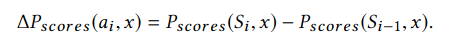

Para defensive_value: \
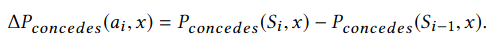


#### O que foi feito
Aqui geramos um dataframe de action values, o qual reúne as métricas de Pscores, Pconcedes vaep_value com dados de ações propriamente ditas, como coordenadas de início e fim, jogador que realizou a ação, etc. \
O dataframe retornado sumariza os dados principais e cáculo de VAEP para cada ação, como descrito no paper. Ele dá uma noção geral dos itens e materializa o conhecimento visto até a seção 4.

### Player Ratings

In [30]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

In [31]:
minutes_per_season = {}
minutes_per_season['Spain'] = calculate_minutes_per_season(minutes['Spain'])

In [32]:
def calculate_player_ratings(action_values, minutes_per_season, players):
    player_ratings = action_values.groupby(by='player_id', as_index=False).agg({'vaep_value': 'sum'}).rename(columns={'vaep_value': 'vaep_total'})
    player_ratings = player_ratings.merge(minutes_per_season, on=['player_id'], how='left')
    player_ratings['vaep_p90'] = player_ratings['vaep_total'] / player_ratings['minutes_played'] * 90
    player_ratings = player_ratings[player_ratings['minutes_played'] >= 600].sort_values(by='vaep_p90', ascending=False).reset_index(drop=True)
    player_ratings = player_ratings.merge(players, on=['player_id'], how='left')
    player_ratings = player_ratings[['player_id', 'player_name', 'minutes_played', 'vaep_total', 'vaep_p90']]

    return player_ratings

In [33]:
player_ratings = {}
player_ratings['Spain'] = calculate_player_ratings(action_values=action_values['Spain'], minutes_per_season=minutes_per_season['Spain'], players=players)

In [35]:
player_ratings['Spain'].head(10)

,player_id,player_name,minutes_played,vaep_total,vaep_p90
0,3359,Lionel Andrés Messi Cuccittini,3108.0,35.891377,1.039326
1,8278,Gareth Frank Bale,1850.0,14.323647,0.696826
2,3802,Philippe Coutinho Correia,1329.0,10.036555,0.679676
3,3322,Cristiano Ronaldo dos Santos Aveiro,2355.0,17.279105,0.660348
4,3682,Antoine Griezmann,2591.0,18.149570,0.630437
5,225946,Arnaldo Antonio Sanabria Ayala,902.0,6.134126,0.612052
6,3840,Iago Aspas Juncal,3038.0,20.002288,0.592563
7,280383,Enis Bardhi,1637.0,10.188202,0.560133
8,3425,Iker Muniain Goñi,816.0,4.983323,0.549631
9,250885,Santiago Mina Lorenzo,1623.0,9.688416,0.537250


### 6 - Acha que o Top 5 da lista é bem representativo? Compare esse ranqueamento do VAEP com o do xT da Atividade 4. Qual você acha que é mais representativo?
O Top 5 da lista são jogadores reconhecidos pelo seu talento e impacto em campo na laLiga durante a temporada analisada, portanto é um ranqueamento bem representativo. \
Comparando esse ranking com o do xT, temos que a única semelhança é a presença de Messi no topo da lista. Comparando as duas métricas, podemos ver que o VAEP é mais representativo, pois ele leva em consideração o contexto da partida, enquanto o xT é baseado nas posições da bola somente do time que está atacando. Pode-se dizer que o VAEP constrói uma análise mais completa.

#### O que foi feito
Por fim geramos um dataframe de player ratings, dando a cada um dos jogadores com mais de 600 minutos jogados um valor de VAEP por 90 minutos e o total.

A classificação de jogadores a partir do valor do seu VAEP pode ser encontrada na seção 3.2 do paper.